In [2]:
import cv2 as cv
import numpy as np
import math
import time
from matplotlib import pyplot as plt

# Constants for the number of windows in rows and columns
n = 2 # number of rows (windows on columns)
m = 2 # number of columns (windows on rows)
EPSILON = 0.00001
# GAMMA and IDEAL_VARIANCE might need adjustment based on the image
GAMMA = 1 # Big GAMMA >> Big mean >> More Brightness
IDEAL_VARIANCE = 0.35 # Big value >> Big variance >> Big lambda >> more contrast

# File path to the image
file_path = '/content/sea.jpg'
# Read the image from file
img = cv.imread(file_path)

if img is None:
    # Error message if the image is not loaded
    print("Error: Image not loaded. Check the file path and name.")
else:
    # Convert the image to grayscale
    layer = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Get the width and height of the image
    WIDTH = layer.shape[1]
    HEIGHT = layer.shape[0]

    # Success message for image loading and conversion
    print("Image loaded and converted successfully.")

# Define the coordinates for the region of interest (ROI)
x0, x1, y0, y1 = 0, WIDTH - 1, 0, HEIGHT - 1


Image loaded and converted successfully.


In [3]:
def phy(value):
    """
    Apply the hyperbolic tangent transformation.
    This function maps value from [-1, 1] to R using the hyperbolic tangent.
    """
    return 0.5 * np.log((1 + value) / ((1 - value) + EPSILON))

def multiplication(value1, value2):
    """
    Multiplies two transformed values.
    """
    return phy(value1) * phy(value2)

def norm(value):
    """
    Returns the norm of the transformed value.
    """
    return abs(phy(value))

def scalar_multiplication(scalar, value):
    """
    Scalar multiplication in the transformed domain.
    """
    s = (1 + value) ** scalar
    z = (1 - value) ** scalar
    res = (s - z) / (s + z + EPSILON)
    return res

def addition(value1, value2):
    """
    Adds two values in the transformed domain.
    """
    res = (value1 + value2) / (1 + (value1 * value2) + EPSILON)
    return res

def subtract(value1, value2):
    """
    Subtracts two values in the transformed domain.
    """
    res = (value1 - value2) / (1 - (value1 * value2) + EPSILON)
    return res

def C(m, i):
    """
    Calculates the binomial coefficient.
    """
    return math.factorial(m) / ((math.factorial(i) * math.factorial(m - i)) + EPSILON)

def qx(i, x):
    """
    Calculates the weighting factor for the x-axis.
    """
    if x == WIDTH - 1:
        return 0
    return C(m, i) * (np.power((x - x0) / (x1 - x), i) * np.power((x1 - x) / (x1 - x0), m))

def qy(j, y):
    """
    Calculates the weighting factor for the y-axis.
    """
    if y == HEIGHT - 1:
        return 0
    return C(n, j) * (np.power((y - y0) / (y1 - y), j) * np.power((y1 - y) / (y1 - y0), n))

def p(i, j, x, y):
    """
    Calculates the combined weighting factor for both x and y axes.
    """
    return qx(i, x) * qy(j, y)

def mapping(img, source, dest):
    """
    Maps the pixel values from the source range to the destination range.
    """
    return (dest[1] - dest[0]) * ((img - source[0]) / (source[1] - source[0])) + dest[0]

In [4]:
e_layer_gray = mapping(layer, (0, 255), (-1, 1))

In [5]:
def cal_ps_ws(m, n, w, h, gamma):
    # Initialize ps with zeros of shape (m, n, w, h)
    ps = np.zeros((m, n, w, h))

    # Fill ps array with the values calculated by p(i, j, k, l)
    for i in range(m):
        for j in range(n):
            for k in range(w):
                for l in range(h):
                    ps[i, j, k, l] = p(i, j, k, l)

    # Initialize ws with zeros of shape (m, n, w, h)
    ws = np.zeros((m, n, w, h))

    # Precompute ps to the power of gamma
    ps_power_gamma = np.power(ps, gamma)

    # Calculate ws values
    for k in range(w):
        for l in range(h):
            # Sum of ps_power_gamma across the first two dimensions
            ps_sum = np.sum(ps_power_gamma[:, :, k, l]) + EPSILON
            for i in range(m):
                for j in range(n):
                    ws[i, j, k, l] = ps_power_gamma[i, j, k, l] / ps_sum

    return ps, ws

print('Ps and Ws calculation is in progress...')
start = time.time()
ps, ws = cal_ps_ws(m, n, WIDTH, HEIGHT, GAMMA)
end = time.time()
print('Ps and Ws calculation has completed successfully in '+str(end-start)+' s')


Ps and Ws calculation is in progress...
Ps and Ws calculation has completed successfully in 10.7704017162323 s


In [6]:
def cal_means_variances_lamdas(w, e_layer):
    # Initialize matrices for means, variances, lamdas, and taos
    means = np.zeros((m, n))
    variances = np.zeros((m, n))
    lamdas = np.zeros((m, n))
    taos = np.zeros((m, n))

    def window_card(w):
        """
        Calculate the cardinality of the window.
        """
        return np.sum(w)

    def window_mean(w, i, j):
        """
        Calculate the mean value of the window.
        """
        mean = 0
        for k in range(HEIGHT):
            for l in range(WIDTH):
                mean = addition(mean, scalar_multiplication(w[i, j, l, k], e_layer[k, l]))
        mean /= window_card(w[i, j])
        return mean

    def window_variance(w, i, j):
        """
        Calculate the variance of the window.
        """
        variance = 0
        for k in range(HEIGHT):
            for l in range(WIDTH):
                variance += w[i, j, l, k] * np.power(norm(subtract(e_layer[k, l], means[i, j])), 2)
        variance /= window_card(w[i, j])
        return variance

    def window_lamda(w, i, j):
        """
        Calculate the lambda value of the window.
        """
        return np.sqrt(IDEAL_VARIANCE) / (np.sqrt(variances[i, j]) + EPSILON)

    def window_tao(w, i, j):
        """
        Calculate the tao value of the window.
        """
        return window_mean(w, i, j)

    # Calculate means, variances, lamdas, and taos for each window
    for i in range(m):
        for j in range(n):
            means[i, j] = window_mean(ws, i, j)
            variances[i, j] = window_variance(ws, i, j)
            lamdas[i, j] = window_lamda(ws, i, j)
    taos = means.copy()

    return means, variances, lamdas, taos

print('Means, variances, lamdas, and taos calculation is in progress...')
start = time.time()
means, variances, lamdas, taos = cal_means_variances_lamdas(ws, e_layer_gray)
end = time.time()
print('Means, variances, lamdas, and taos calculation is finished in ' + str(end-start) + ' s')


Means, variances, lamdas, and taos calculation is in progress...
Means, variances, lamdas, and taos calculation is finished in 4.739808082580566 s


In [7]:
def window_enh(w, i, j, e_layer):
    return scalar_multiplication(lamdas[i, j], subtract(e_layer, taos[i, j]))

In [8]:
def image_enh(w, e_layer):
    # Initialize the new image with zeros, having the same shape as e_layer
    new_image = np.zeros(e_layer.shape)
    width = e_layer.shape[1]
    height = e_layer.shape[0]

    # Transpose the entire weight matrix once
    w_transposed = w.transpose((0, 1, 3, 2))

    for i in range(m):
        for j in range(n):
            # Enhance the current window
            win = window_enh(w, i, j, e_layer)
            # Use the pre-transposed weight matrix
            w1 = w_transposed[i, j]

            # Accumulate the enhanced values into the new image
            for k in range(width):
                for l in range(height):
                    new_image[l, k] = addition(new_image[l, k], scalar_multiplication(w1[l, k], win[l, k]))

    return new_image


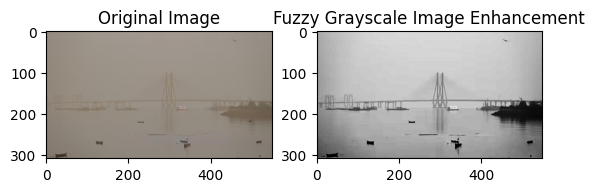

In [12]:
def one_layer_enhancement(e_layer):
    # Enhance the image using the weight matrix ws and e_layer
    new_E_image = image_enh(ws, e_layer)

    # Map the enhanced image values from range (-1, 1) to (0, 255)
    res_image = mapping(new_E_image, (-1, 1), (0, 255))

    # Round the mapped values to the nearest integer
    res_image = np.round(res_image)

    # Convert the rounded values to unsigned 8-bit integer type
    res_image = res_image.astype(np.uint8)

    return res_image

# Apply the enhancement to the grayscale image layer
res_img = one_layer_enhancement(e_layer_gray)

# Plot the original and enhanced images side by side
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(res_img, cmap='gray')
plt.title('Fuzzy Grayscale Image Enhancement')

# Display the plot
plt.show()

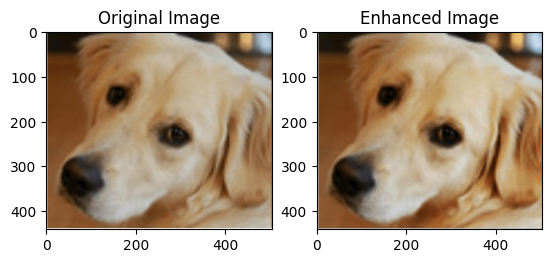

In [13]:
# Constants
n = 2  # number of rows (windows)
m = 2  # number of columns (windows)
GAMMA = 1
EPSILON = 0.00001
IDEAL_VARIANCE = 0.35

# Load the image
file_path = '/content/sathiya.png'
img = cv.imread(file_path)
WIDTH = img.shape[1]
HEIGHT = img.shape[0]
x0, x1, y0, y1 = 0, WIDTH - 1, 0, HEIGHT - 1

# Image fuzzification
layer_b, layer_g, layer_r = cv.split(img)  # Split the image into blue, green, and red layers

# Map the pixel values from range (0, 255) to (-1, 1)
e_layer_b = mapping(layer_b, (0, 255), (-1, 1))
e_layer_g = mapping(layer_g, (0, 255), (-1, 1))
e_layer_r = mapping(layer_r, (0, 255), (-1, 1))

# Calculate the mean of the three layers
e_layer_rgb = scalar_multiplication(1/3, addition(addition(e_layer_b, e_layer_g), e_layer_r))

# Calculate Ps and Ws
ps, ws = cal_ps_ws(m, n, WIDTH, HEIGHT, GAMMA)

# Calculate means, variances, lamdas, and taos
means, variances, lamdas, taos = cal_means_variances_lamdas(ws, e_layer_rgb)

# Enhance each layer
res_r = one_layer_enhancement(e_layer_r)
res_g = one_layer_enhancement(e_layer_g)
res_b = one_layer_enhancement(e_layer_b)

# Merge the enhanced layers back into a color image
res_img = cv.merge([res_b, res_g, res_r])

# Display the original and enhanced images
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))  # Display the original image in RGB
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(cv.cvtColor(res_img, cv.COLOR_BGR2RGB))  # Display the enhanced image in RGB
plt.title('Enhanced Image')

plt.show()